In [3]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

import prophet

warnings.filterwarnings('ignore')

/Users/benmagevney/miniconda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# suppress the prophet logs
import logging

class SuppressFilter(logging.Filter):
    def filter(self, record):
        return False  

logger = logging.getLogger('cmdstanpy')
logger.addFilter(SuppressFilter())

# Prophet Univariate

In [8]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../../data/regional_datasets/univariate/esc_data_univ.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/univariate/mid_atlantic_data_univ.csv')
mountain = pd.read_csv('../../data/regional_datasets/univariate/mountain_data_univ.csv')
new_england = pd.read_csv('../../data/regional_datasets/univariate/new_england_data_univ.csv')
pacific = pd.read_csv('../../data/regional_datasets/univariate/pacific_data_univ.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/univariate/south_atlantic_data_univ.csv')
wnc = pd.read_csv('../../data/regional_datasets/univariate/wnc_data_univ.csv')
wsc = pd.read_csv('../../data/regional_datasets/univariate/wsc_data_univ.csv')

# ignore values before march 
enc = enc[enc.date >= "2020-03-01"]
esc = esc[esc.date >= "2020-03-01"]
mid_atlantic = mid_atlantic[mid_atlantic.date >= "2020-03-01"]
mountain = mountain[mountain.date >= "2020-03-01"]
new_england = new_england[new_england.date >= "2020-03-01"]
pacific = pacific[pacific.date >= "2020-03-01"]
south_atlantic = south_atlantic[south_atlantic.date >= "2020-03-01"]
wnc = wnc[wnc.date >= "2020-03-01"]
wsc = wsc[wsc.date >= "2020-03-01"]


datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df['date'] = pd.to_datetime(df['date'])
    df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
    df.sort_index(inplace=True)


In [28]:
def baseline_prophet(df, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    subset = df[['date', 'new_confirmed']].rename(columns={'date': 'ds', 'new_confirmed': 'y'})

    train, temp_test_df = train_test_split(subset, test_size=0.2, shuffle=False)
    val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    test_y = test['y']

    train_val = pd.concat([train, val])

    model = prophet.Prophet()
    model = model.fit(train_val)

    # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
    pred = model.predict(test)
    pred_yhat = pred['yhat']
    pred_yhat[pred_yhat < 0] = 0

    # calculate metrics
    mae = mean_absolute_error(test_y, pred_yhat)
    mse = mean_squared_error(test_y, pred_yhat)
    rmse = mean_squared_error(test_y, pred_yhat, squared=False)
    mase = mean_absolute_scaled_error(test_y, pred_yhat, y_train=train_val['y'])

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Univariate Prophet Predictions for {region}')
        plt.plot(test['ds'], test_y, label='True')
        plt.plot(pred['ds'], pred_yhat, label='Predicted')
        # uncomment to show confidence interval
        # plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
        plt.legend() 
        plt.show()

Training model for East North Central...
MAE: 7938.48
MSE: 96797633.63
RMSE: 9838.58
MASE: 0.93


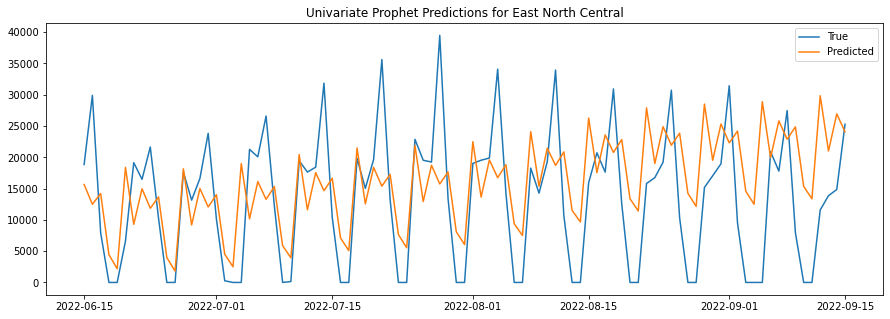


Training model for East South Central...
MAE: 5792.47
MSE: 51231083.85
RMSE: 7157.59
MASE: 1.69


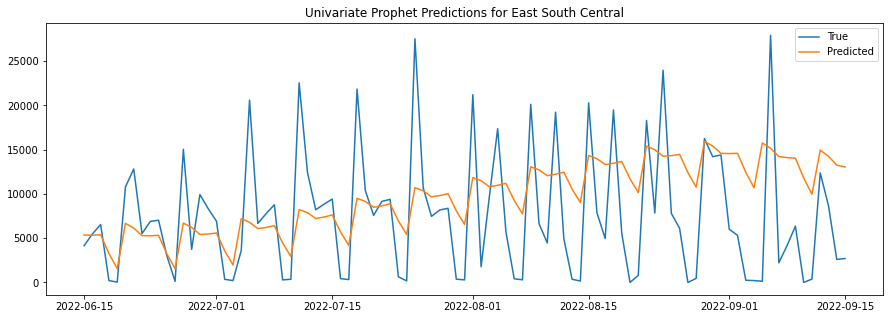


Training model for Mid-Atlantic...
MAE: 5914.6
MSE: 62353890.59
RMSE: 7896.45
MASE: 2.38


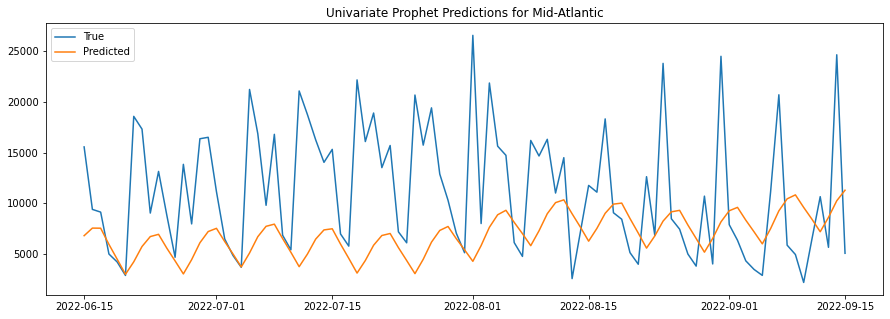


Training model for Mountain...
MAE: 7066.41
MSE: 72357068.56
RMSE: 8506.3
MASE: 2.11


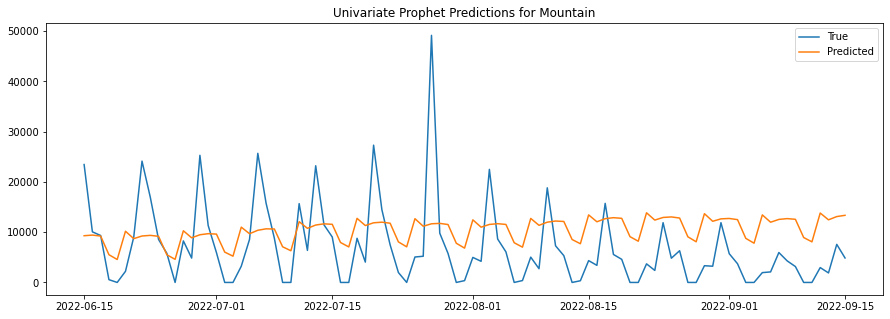


Training model for New England...
MAE: 3208.41
MSE: 15423382.63
RMSE: 3927.26
MASE: 1.16


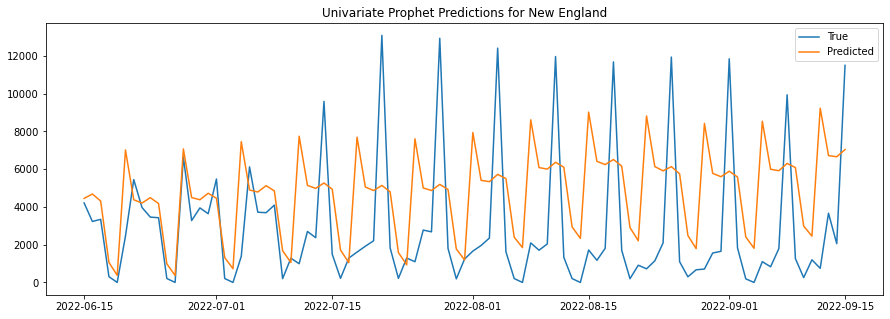


Training model for Pacific...
MAE: 18789.69
MSE: 453607007.51
RMSE: 21298.05
MASE: 2.38


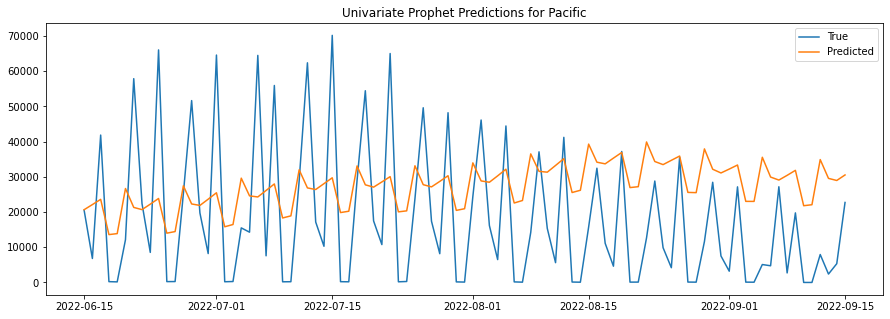


Training model for South Atlantic...
MAE: 20287.52
MSE: 564440889.61
RMSE: 23757.96
MASE: 1.81


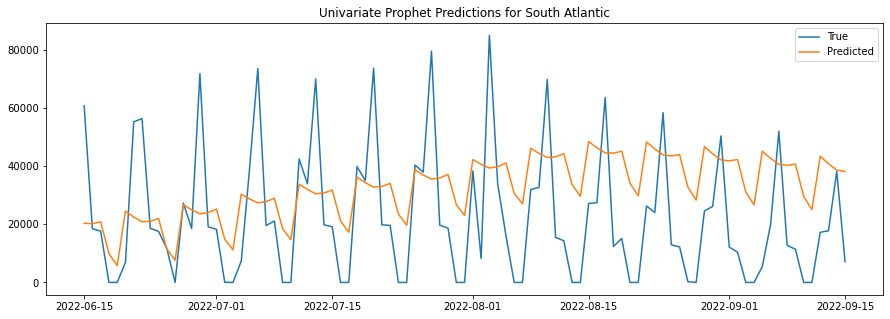


Training model for West North Central...
MAE: 3868.07
MSE: 19984435.83
RMSE: 4470.4
MASE: 1.18


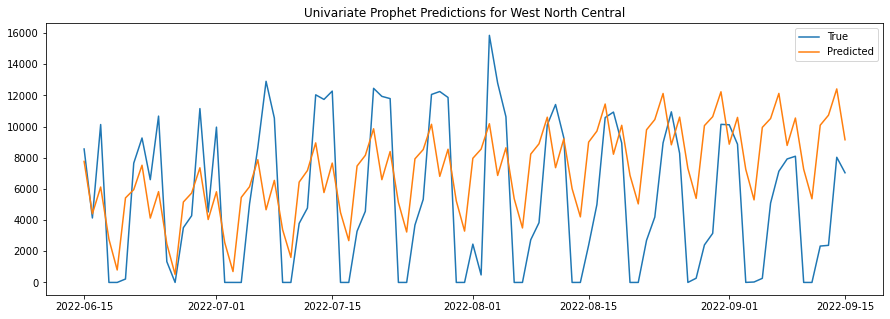


Training model for West South Central...
MAE: 7865.19
MSE: 97398742.14
RMSE: 9869.08
MASE: 1.75


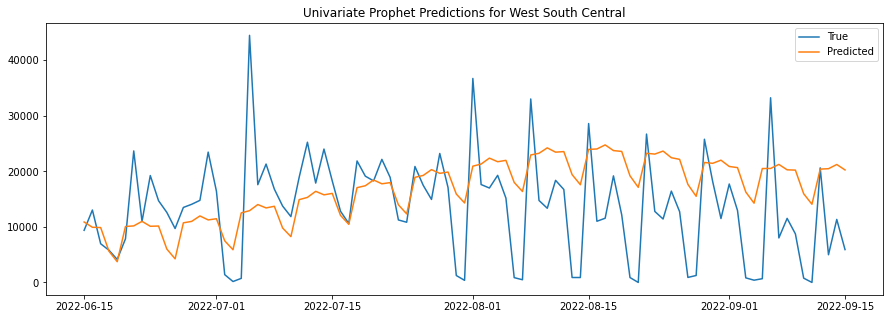


--- 3.08 seconds ---


In [29]:
start_time = time.time()
for df in datasets:
    baseline_prophet(df, plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Parameter Tune

In [44]:
# params_grid = {'changepoint_prior_scale':[0.001, 0.01, 0.1, 0.5, 1.0],
#               'seasonality_prior_scale':[0.1, 1.0, 10.0, 20.0],
#               'n_changepoints': [10, 25, 50, 100],}
params_grid = {'changepoint_prior_scale':[0.001,0.005,0.01,0.025, 0.05, 0.1],
              'seasonality_prior_scale':[0.1,0.25,0.5,1,2,5]}
grid = ParameterGrid(params_grid)
def optimize_parameters(df):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    subset = df[['date', 'new_confirmed']].rename(columns={'date': 'ds', 'new_confirmed': 'y'})

    train, temp_test_df = train_test_split(subset, test_size=0.2, shuffle=False)
    val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    val_y = val['y']
    # test_y = test['y']

    results = []
    for params in grid:

        model = prophet.Prophet(**params)
        # model.add_country_holidays(country_name='US')
        model = model.fit(train)

        # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
        pred = model.predict(val)
        pred_yhat = pred['yhat']
        pred_yhat[pred_yhat < 0] = 0

        # calculate metrics
        mae = mean_absolute_error(val_y, pred_yhat)
        rmse = mean_squared_error(val_y, pred_yhat, squared=False)
        mase = mean_absolute_scaled_error(val_y, pred_yhat, y_train=train['y'])

        results.append([params["changepoint_prior_scale"], params["seasonality_prior_scale"] , mae, rmse, mase])
                
    results = pd.DataFrame(results, columns=["changepoint", "seasonality", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())


In [45]:
start_time = time.time()
for df in datasets:
    optimize_parameters(df)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
   changepoint  seasonality          mae          rmse      mase
2        0.001         0.50  8900.172202  10659.363189  1.037336
3        0.001         1.00  8903.013824  10660.032902  1.037667
4        0.001         2.00  8904.842154  10658.047103  1.037880
5        0.001         5.00  8905.440444  10658.498178  1.037950
1        0.001         0.25  8975.795036  10712.517745  1.046150

Training model for East South Central...
   changepoint  seasonality          mae         rmse      mase
4        0.001          2.0  3719.111472  4120.518463  1.040334
3        0.001          1.0  3734.498780  4134.907269  1.044638
2        0.001          0.5  3744.646326  4143.244979  1.047476
5        0.001          5.0  3752.141075  4149.469479  1.049573
0        0.001          0.1  3799.073230  4187.153447  1.062701

Training model for Mid-Atlantic...
    changepoint  seasonality          mae          rmse      mase
30          0.1         0.10  8821.716076

In [34]:
start_time = time.time()
for df in datasets:
    optimize_parameters(df)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


    changepoint  seasonality  n_changepoints          mae          rmse  \
76        1.000          0.1             100  8791.958431  13470.009661   
72        1.000          0.1              50  8828.078504  13476.555115   
68        1.000          0.1              25  8885.361856  13487.312483   
5         0.001          1.0              25  8903.013824  10660.032902   
6         0.001         10.0              25  8904.771248  10658.026510   

        mase  
76  1.024724  
72  1.028933  
68  1.035610  
5   1.037667  
6   1.037872  

Training model for East South Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


    changepoint  seasonality  n_changepoints          mae         rmse  \
64          1.0          0.1              10  2355.538657  3742.245703   
67          1.0         20.0              10  2376.814113  3787.157556   
66          1.0         10.0              10  2380.995803  3790.390519   
65          1.0          1.0              10  2390.477127  3805.483855   
72          1.0          0.1              50  2406.987743  3824.853268   

        mase  
64  0.658906  
67  0.664858  
66  0.666027  
65  0.668680  
72  0.673298  

Training model for Mid-Atlantic...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


    changepoint  seasonality  n_changepoints          mae         rmse  \
78          1.0         10.0             100  6475.600135  8236.612422   
76          1.0          0.1             100  6694.950339  8438.644800   
72          1.0          0.1              50  6992.057011  9047.746047   
79          1.0         20.0             100  7060.935741  9242.107297   
77          1.0          1.0             100  7119.666825  9256.653555   

        mase  
78  2.895571  
76  2.993653  
72  3.126505  
79  3.157304  
77  3.183566  

Training model for Mountain...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


    changepoint  seasonality  n_changepoints          mae         rmse  \
0         0.001          0.1              10  4183.319245  5209.163054   
1         0.001          1.0              10  4224.654230  5233.132871   
2         0.001         10.0              10  4226.279439  5234.150584   
3         0.001         20.0              10  4226.303480  5234.168974   
64        1.000          0.1              10  4479.013691  6740.071747   

        mase  
0   1.260889  
1   1.273348  
2   1.273838  
3   1.273845  
64  1.350014  

Training model for New England...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


   changepoint  seasonality  n_changepoints          mae         rmse  \
4        0.001          0.1              25  2843.225618  3932.885054   
7        0.001         20.0              25  2846.247118  3931.802212   
6        0.001         10.0              25  2846.359208  3931.812598   
5        0.001          1.0              25  2848.683320  3932.619251   
1        0.001          1.0              10  2856.250986  3927.266268   

       mase  
4  1.069511  
7  1.070648  
6  1.070690  
5  1.071564  
1  1.074411  

Training model for Pacific...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


   changepoint  seasonality  n_changepoints          mae          rmse  \
2        0.001         10.0              10  9299.373082  14252.223602   
3        0.001         20.0              10  9299.645757  14252.187896   
1        0.001          1.0              10  9301.569376  14252.173936   
0        0.001          0.1              10  9335.050995  14238.806766   
4        0.001          0.1              25  9467.286574  14123.201538   

       mase  
2  1.310390  
3  1.310428  
1  1.310699  
0  1.315417  
4  1.334051  

Training model for South Atlantic...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


   changepoint  seasonality  n_changepoints           mae          rmse  \
1        0.001          1.0              10  11680.304459  14919.630555   
3        0.001         20.0              10  11690.807158  14926.314458   
2        0.001         10.0              10  11709.049757  14938.669078   
0        0.001          0.1              10  11741.201297  14959.789813   
5        0.001          1.0              25  12074.735208  15215.896070   

       mase  
1  1.030489  
3  1.031415  
2  1.033025  
0  1.035861  
5  1.065287  

Training model for West North Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


    changepoint  seasonality  n_changepoints          mae         rmse  \
65          1.0          1.0              10  2808.668557  4040.547979   
69          1.0          1.0              25  2820.716818  4041.977233   
67          1.0         20.0              10  2826.968941  4042.810426   
72          1.0          0.1              50  2827.466543  4043.547896   
64          1.0          0.1              10  2827.873778  4043.106034   

        mase  
65  0.819986  
69  0.823504  
67  0.825329  
72  0.825474  
64  0.825593  

Training model for West South Central...


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


    changepoint  seasonality  n_changepoints          mae         rmse  \
76        1.000          0.1             100  4417.864232  5684.425997   
1         0.001          1.0              10  4531.551261  5347.276234   
3         0.001         20.0              10  4534.748685  5350.463987   
2         0.001         10.0              10  4535.038060  5350.750075   
0         0.001          0.1              10  4546.037649  5361.322739   

        mase  
76  0.924424  
1   0.948212  
3   0.948881  
2   0.948942  
0   0.951244  

--- 427.67 seconds ---


In [5]:
# parameters = {
#     "East North Central": {
#         "changepoint_prior_scale": 1.00, 
#         "seasonality_prior_scale": 0.1,
#         "n_changepoints": 100},
#     "East South Central": { 
#         "changepoint_prior_scale": 1.00, 
#         "seasonality_prior_scale": 0.1,
#         "n_changepoints": 10},
#     "Mid-Atlantic":  {
#         "changepoint_prior_scale": 1.00, 
#         "seasonality_prior_scale": 10.0,
#         "n_changepoints": 100},
#     "Mountain":  {
#         "changepoint_prior_scale": 0.001, 
#         "seasonality_prior_scale": 0.1,
#         "n_changepoints": 10},
#     "New England": {
#         "changepoint_prior_scale": 0.001, 
#         "seasonality_prior_scale": 10.0,
#         "n_changepoints": 25},
#     "Pacific":  {
#         "changepoint_prior_scale": 0.001, 
#         "seasonality_prior_scale": 10.0,
#         "n_changepoints": 10},
#     "South Atlantic": {
#         "changepoint_prior_scale": 0.001, 
#         "seasonality_prior_scale": 1,
#         "n_changepoints": 10},
#     "West North Central": {
#         "changepoint_prior_scale": 1.00, 
#         "seasonality_prior_scale": 1.0,
#         "n_changepoints": 10},
#     "West South Central":  {
#         "changepoint_prior_scale": 1.00, 
#         "seasonality_prior_scale": 0.1,
#         "n_changepoints": 100},

# }
parameters = {
    "East North Central": {
        "changepoint_prior_scale": 0.001, 
        "seasonality_prior_scale": 0.50,
    },
    "East South Central": { 
        "changepoint_prior_scale": 0.001, 
        "seasonality_prior_scale": 2.0,
        },
    "Mid-Atlantic":  {
        "changepoint_prior_scale": 0.1, 
        "seasonality_prior_scale": 0.10,
        },
    "Mountain":  {
        "changepoint_prior_scale": 0.005, 
        "seasonality_prior_scale": 0.5,
        },
    "New England": {
        "changepoint_prior_scale": 0.001, 
        "seasonality_prior_scale": 0.1,
        },
    "Pacific":  {
        "changepoint_prior_scale": 0.001, 
        "seasonality_prior_scale": 0.10,
        },
    "South Atlantic": {
        "changepoint_prior_scale": 0.001, 
        "seasonality_prior_scale": 1,
        },
    "West North Central": {
        "changepoint_prior_scale": 0.001, 
        "seasonality_prior_scale": 0.25,
        },
    "West South Central":  {
        "changepoint_prior_scale": 0.005, 
        "seasonality_prior_scale": 0.25,
        },

}

In [9]:
def build_prophet(df, params=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    subset = df[['date', 'new_confirmed']].rename(columns={'date': 'ds', 'new_confirmed': 'y'})

    train_df, temp_test_df = train_test_split(subset, test_size=0.2, shuffle=False)
    val, test  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)
    # val_y = val['y']
    test_y = test['y']
    train_val = pd.concat([train_df, val])

    if params:
        model = prophet.Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],
                                seasonality_prior_scale=params["seasonality_prior_scale"],
        )
    else:
        model = prophet.Prophet()
    model = model.fit(train_val)

    # pred, conf_int = model.predict(n_periods=size, return_conf_int=True)
    pred = model.predict(test)
    pred_yhat = pred['yhat']
    pred_yhat[pred_yhat < 0] = 0

    # calculate metrics
    mae = mean_absolute_error(test_y, pred_yhat)
    # mse = mean_squared_error(test_y, pred_yhat)
    rmse = mean_squared_error(test_y, pred_yhat, squared=False)
    mase = mean_absolute_scaled_error(test_y, pred_yhat, y_train=train_val['y'])

    print(f'MAE: {round(mae, 2)}')
    # print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Univariate Prophet Predictions for {region}')
        plt.plot(test['ds'], test_y, label='True')
        plt.plot(pred['ds'], pred_yhat, label='Predicted')
        # uncomment to show confidence interval
        # plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
        plt.legend() 

        plt.savefig(f"plots/{region}_prophet_univariate.png")
        plt.show()

    return region, mase, rmse, mae

Training model for East North Central...
MAE: 7723.56
RMSE: 9703.77
MASE: 0.9


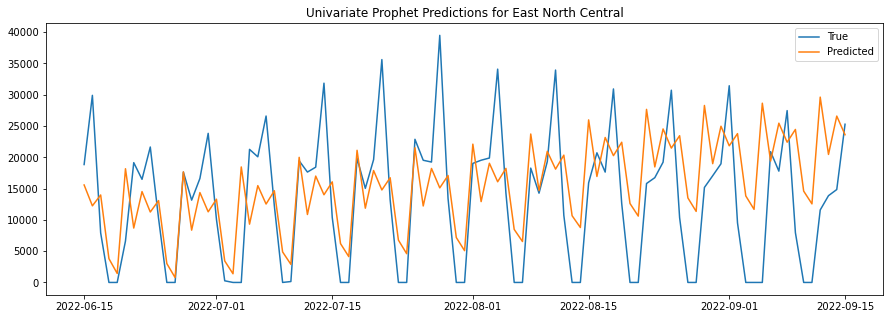


Training model for East South Central...
MAE: 6752.02
RMSE: 8155.43
MASE: 1.97


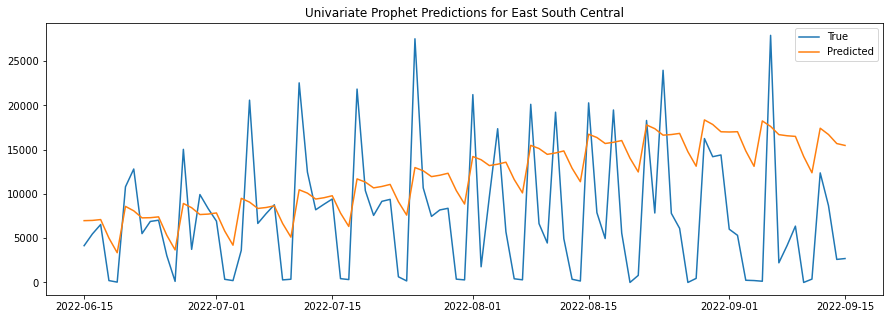


Training model for Mid-Atlantic...
MAE: 7984.02
RMSE: 9727.24
MASE: 3.21


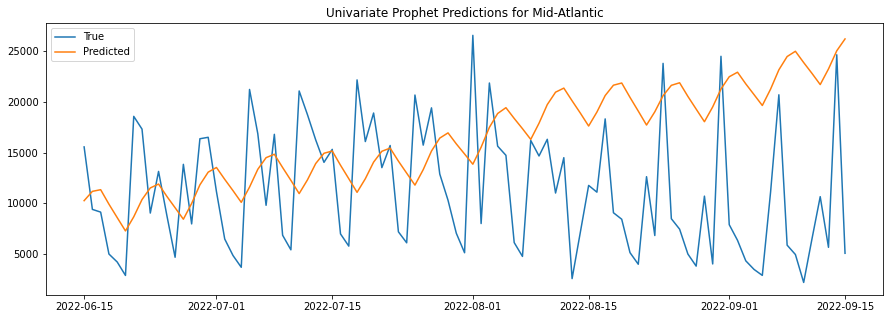


Training model for Mountain...
MAE: 6446.79
RMSE: 8076.72
MASE: 1.93


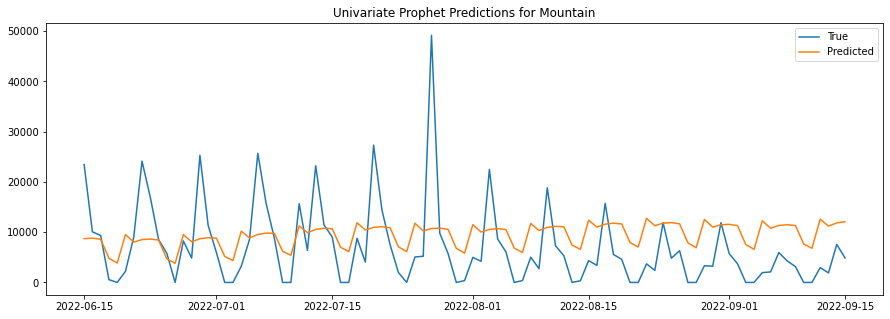


Training model for New England...
MAE: 2946.27
RMSE: 3751.02
MASE: 1.07


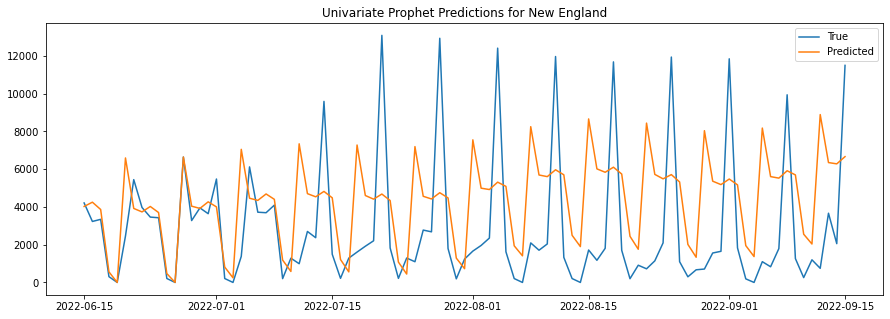


Training model for Pacific...
MAE: 20237.95
RMSE: 22273.2
MASE: 2.56


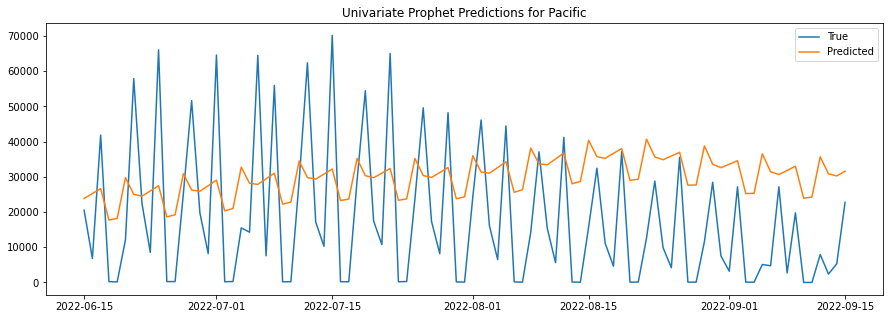


Training model for South Atlantic...
MAE: 24631.38
RMSE: 27580.88
MASE: 2.2


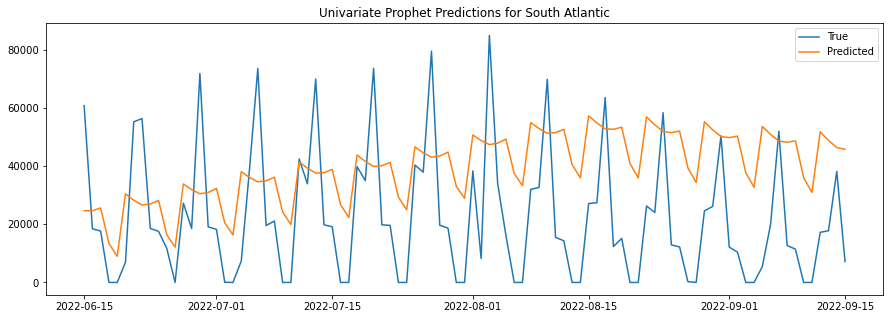


Training model for West North Central...
MAE: 4533.76
RMSE: 5279.79
MASE: 1.38


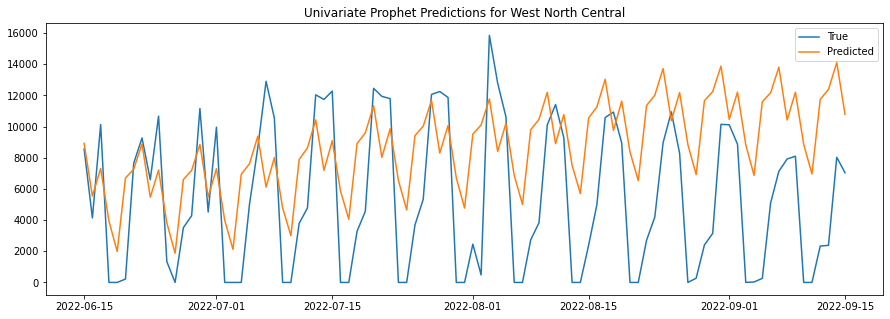


Training model for West South Central...
MAE: 8214.34
RMSE: 10395.5
MASE: 1.83


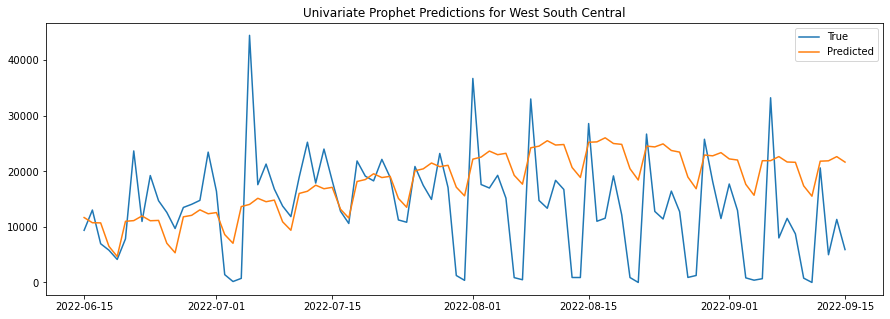


--- 3.67 seconds ---
               region      mase          rmse           mae
0  East North Central  0.904382   9703.774790   7723.564452
1  East South Central  1.970916   8155.431625   6752.020472
2        Mid-Atlantic  3.210855   9727.239849   7984.020494
3            Mountain  1.927102   8076.718019   6446.788923
4         New England  1.068345   3751.019803   2946.273347
5             Pacific  2.564021  22273.202155  20237.945765
6      South Atlantic  2.203210  27580.881663  24631.376518
7  West North Central  1.384202   5279.793696   4533.756922
8  West South Central  1.831401  10395.501655   8214.341759


In [10]:
start_time = time.time()
results = []
for df in datasets:
    region, mase, rmse, mae = build_prophet(df, params=parameters[df["region"].iloc[0]], plot=True)
    results.append([region, mase, rmse, mae])
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

results = pd.DataFrame(results, columns=["region", "mase", "rmse", "mae"])
print(results)